In [0]:
!curl https://download.pytorch.org/tutorial/data.zip -o sample_data/data.zip
!unzip sample_data/data.zip -d sample_data/data/

In [2]:
!ls sample_data/data/data/names

Arabic.txt   English.txt  Irish.txt	Polish.txt	Spanish.txt
Chinese.txt  French.txt   Italian.txt	Portuguese.txt	Vietnamese.txt
Czech.txt    German.txt   Japanese.txt	Russian.txt
Dutch.txt    Greek.txt	  Korean.txt	Scottish.txt


In [0]:
from io import open
import glob
import os
import unicodedata
import string
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

In [5]:
path = Path('sample_data/data/data/names')
all_files = list(path.iterdir())
all_files

[PosixPath('sample_data/data/data/names/Italian.txt'),
 PosixPath('sample_data/data/data/names/English.txt'),
 PosixPath('sample_data/data/data/names/Czech.txt'),
 PosixPath('sample_data/data/data/names/Portuguese.txt'),
 PosixPath('sample_data/data/data/names/Vietnamese.txt'),
 PosixPath('sample_data/data/data/names/Japanese.txt'),
 PosixPath('sample_data/data/data/names/Scottish.txt'),
 PosixPath('sample_data/data/data/names/French.txt'),
 PosixPath('sample_data/data/data/names/Spanish.txt'),
 PosixPath('sample_data/data/data/names/Polish.txt'),
 PosixPath('sample_data/data/data/names/Korean.txt'),
 PosixPath('sample_data/data/data/names/Chinese.txt'),
 PosixPath('sample_data/data/data/names/Irish.txt'),
 PosixPath('sample_data/data/data/names/Dutch.txt'),
 PosixPath('sample_data/data/data/names/German.txt'),
 PosixPath('sample_data/data/data/names/Russian.txt'),
 PosixPath('sample_data/data/data/names/Arabic.txt'),
 PosixPath('sample_data/data/data/names/Greek.txt')]

In [6]:
def find_files(path):
    return glob.glob(path)

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn'
                   and c in all_letters)

def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

category_lines = {}
all_categories = []
for filename in all_files:
    category = filename.stem
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicode_to_ascii("O'Néàl"))

# categories: 18 ['Italian', 'English', 'Czech', 'Portuguese', 'Vietnamese', 'Japanese', 'Scottish', 'French', 'Spanish', 'Polish', 'Korean', 'Chinese', 'Irish', 'Dutch', 'German', 'Russian', 'Arabic', 'Greek']
O'Neal


## Data

In [0]:
def category_tensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def input_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)
    return torch.torch.LongTensor(letter_indexes)

## Model

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, inputs):
        hidden = self.init_hidden()
        hidden = hidden.cuda()
        category = category.squeeze(0)
        inputs = inputs.squeeze(0)
        outputs = []
        for inp in inputs:
            category = category.cuda()
            inp = inp.cuda()
            inputs_combined = torch.cat((category, inp, hidden), 1)
            hidden = self.i2h(inputs_combined)
            output = self.i2o(inputs_combined)
            output_combined = torch.cat((hidden, output), 1)
            output = self.o2o(output_combined)
            output = self.dropout(output)
            output = self.softmax(output)
            outputs.append(output)
        return outputs
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
        

In [0]:
# category_line_tensors, input_line_tensors, target_line_tensors = [], [], []
# for category in all_categories:
#     category_line_tensor = category_tensor(category)
#     line = category_lines[category]
#     input_line_tensor = input_tensor(line)
#     target_line_tensor = target_tensor(line)
#     category_line_tensors.append(category_line_tensor)
#     input_line_tensors.append(input_line_tensor)
#     target_line_tensors.append(target_line_tensor)

In [0]:
# len(category_line_tensors), len(input_line_tensors), len(target_line_tensors)

In [0]:
# input_line_tensor.shape

In [0]:
def prepare_data(category_lines):
        data = []
        for key, values in category_lines.items():
            category = category_tensor(key)
            for value in values:
                inputs = input_tensor(value)
                targets = target_tensor(value)
                data.append({
                    'category': category,
                    'inputs': inputs,
                    'targets': targets
                })
        return data

In [13]:
import random
data = prepare_data(category_lines)
n = len(data)
split = int(0.2 * n)
random.shuffle(data)
train_data = data[4014:]
valid_data = data[:4014]
len(train_data), len(valid_data)

(16060, 4014)

In [0]:
class NamedDataset(Dataset):
    def __init__(self, root_dir, data):
        self.root_dir = root_dir
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        category = data['category']
        inputs = data['inputs']
        targets = data['targets']
        return ((category, inputs), targets)

In [0]:
from fastai.text import *

In [0]:
train_ds = NamedDataset(path, train_data)
valid_ds = NamedDataset(path, valid_data)
data_bunch = DataBunch.create(train_ds, valid_ds, bs=1)

In [0]:
rnn = RNN(n_letters, 256, n_letters).cuda()

In [0]:
x, y = next(iter(data_bunch.train_dl))

In [0]:
def custom_loss(pred, targ):
    targ = targ.view(-1, 1)
    loss = 0
    for i in range(len(pred)):
        loss += F.nll_loss(pred[i], targ[i])
    return loss

In [0]:
learn = Learner(data_bunch, rnn, opt_func=optim.Adam, loss_func=custom_loss, metrics=accuracy)

In [46]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


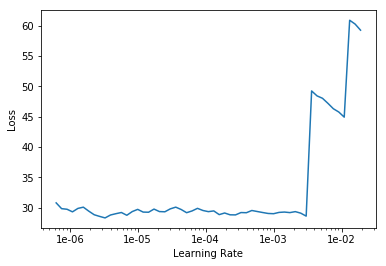

In [48]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, slice(1e-3))